# Parametric projected trap array simulations
the premier high-level notebook in the projected trap array analysis. 
trap arrays can be generated for several configurations given a list of params,
and the simulation data can be saved with sensible names automatically.

for now, this is only intended to handle monochromatic spatially coherent fields.

In [2]:
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from collections import namedtuple
from numpy import real,empty
from scipy.special import jn_zeros
from time import time
import csv

## local imports
import os,sys
sys.path.append(os.path.join("..","."))
from field_funcs import * # my helper functions
from simfuncs import * # for saving/retreiving data

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

# image path 
# imagedir = os.path.join('..','images')
imagedir = os.path.join('.','paper_data')
print("images saved in", imagedir)

# for matplotlib labels
fontsize=14

images saved in .\paper_data


## XY Plots
Intensity slice in x-y plane, where z is the propagation axis

In [81]:
## physics and lens params
lmbda = 8.08e-7
k = 2*pi/lmbda
f1 = .5 # lens focal length [m]
f2 = 0.05
A0 = 1 # input field amplitude

## input mask grid params
xnum = ynum = 10 # number of grid points in each dimension
a = 1e-4
d = 4.3*a # if xnum,ynum are 1, this effectively determines the width of the mask
ta1 = 0 #0.287119 # spot transmittivity for a dark mask
tb1 = 1 # background transmittivity
pts = 1900 ##1100 # grid mesh is pts x pts
padding = pts//2 # int(3*pts/2) #TODO set

# Gaussian beam array object.
param_names = ['type','a1','tb1','ta1','b','dx','dy','phi','a2','tb2','phi_std','pos_std']
gba = namedtuple('gba',param_names,defaults=[0,None,None,None,None]) 

In [82]:
# a = 1e-6
# f1 = 2e-6
b = f1*3.8317/(k*a)
# Fresnel limit
zfresnel = ((k/(8*pi))*(b**2)**2)**(1/3)
print(f"zfresnel={zfresnel*1e3}mm")
print(f2/zfresnel)

zfresnel=22.506098241677567mm
2.2216200899455902


In [83]:
x10/x11

0.6276122375761352

In [84]:
## the Gaussian beams arrays to generate

x11 = jn_zeros(1,1)[0]
x10 = jn_zeros(0,1)[0]

b0 = f1*x11/(a*k) # fourier filter radius for bright aG trap or dark aG trap with ta=0.287
b1 = f1*x10/(a*k) # fourier filter radius for dark aG trap with ta=0

w = 0.01

abright = 1.2e-4
adark = abright*x10/x11
bdual = f1*x11/(k*abright)
print("abright,adark [um]")
print(array([abright, adark])*1e6)
configurations = [
#                     gba('dmd',a,1,0,b0,d,d)
#                     gba('bright',a,0,1,b0,w,w),
#                       gba('bright',a,0.7,1,b0,d,d,phi=0)
#                     gba('bright_phases',a,0,1,b0,d,d,phi_std=0.2),
#                     gba('bright_pos',a,0,1,b0,d,d,pos_std=0.2*a),
#                     gba('bright_asym',a,0,1,b0,d,1.22*d),
#                     gba('dark',a,1,0.287119,b0,d,d),
#                     gba('dark',a,1,0,b1,d,d),
#                     gba('dark',a,1,0,b0*5.52008/3.8317,d,d)
#                     gba('dark_pos',a,tb1,ta1,b0,d,d,pos_std=0.2*a),
#                     gba('dark_asym',a,tb1,ta1,b0,d,1.22*d),
                    gba('bright_dark',abright,0.8,0,bdual,dx=5.16e-4,dy=5.16e-4,a2=adark) # fully dark apertures with a2 (dark) adjusted so b0 works for both traps
#                     gba('bright_dark',a,0.7,0,b0*2.40483/3.8317,d,d,a2=a,phi=180)
                ]

# custom colormap
n_bin = 100
# colorlist = [(0, 0, 0), (1, 0, 0)]  # black to red
# colorlist = [(0, 0, 0),(249/255,15/255,15/255),(249/255, 239/255, 239/255)] # black-red-pink
# colorlist = [(0, 0, 0),(169/255,15/255,15/255),(249/255, 75/255, 75/255)] # black-red-red2
# colorlist = [(0, 0, 0),(169/255,15/255,15/255),(249/255, 75/255, 75/255)] # black-red-red3

# cmap = LinearSegmentedColormap.from_list('my_cmap', colorlist, N=n_bin)
cmap = 'seismic'

abright,adark [um]
[120.          75.31346851]


C:\Users\prest\Documents\Python\fourier-optics\gba\..\.\field_funcs.py:254: ComplexWarning: Casting complex values to real discards the imaginary part
  smask[i,j] = aperture


b=0.002053, a_dark=0.00012, a_bright=7.531346850913622e-05, dx=0.000516, dy=0.000516, xnum=10, ynum=10
zTalbotx=0.006590, zTalboty=0.006590
b=0.002053, a=0.00012, dx=0.000516, dy=0.000516, xnum=10, ynum=10
zTalbotx=0.006590, zTalboty=0.006590
step 0 completed


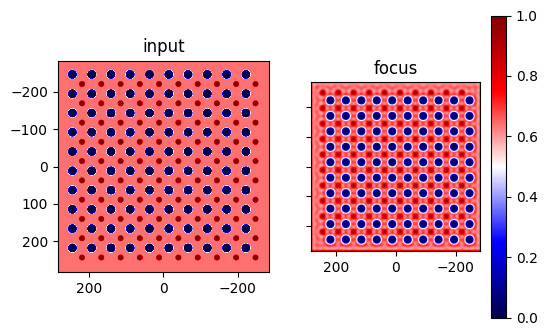

In [85]:
plot=True
savedata=False

# the planes to plot
labels = ['input','focus'] # output axial plane
focalfields = [] # store the output fields from each config

for i,cfg in enumerate(configurations):
    
    # extract the array params
    name,a1,tb1,ta1,b,dx,dy,phi,a2,ta2,phi_std,pos_std = [
        getattr(cfg, attr) for attr in param_names]

    # calculate the Talbot lengths
    Lx2 = f2*dx/f1 # output array periodicity
    Ly2 = f2*dy/f1
    zTalbotx = 2*Lx2**2/lmbda
    zTalboty = 2*Ly2**2/lmbda
        
    if name == 'bright_dark':
        
        # this is the part of the mask for the dark traps
        mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                               phi_std=phi_std, pos_std=pos_std, 
                               aperture=ta1, plate=tb1)
        
        # make a plate with 0s in the background and spots = -tb1,
        # so adding this to the plate we just made will complete the
        # bright-dark mask
        phi_std=None # [rad]
        pos_std=None
        t12 = 0 # plate transmissivity
        mask2, x0pts, w = spot_mask(xnum, ynum, a2, dx, dy, pts,
            phi_std=phi_std, pos_std=pos_std, aperture=1-tb1*exp(-1j*phi*pi/180), plate=t12)#aperture=1-tb1, plate=t12)

        # add phase to the mask background. 
        # warning! this will add phase to the dark trap apertures too, unless they are fully opaque (ta1=0)
        if phi != 0:
            complement, _, _ = spot_mask(xnum, ynum, a1, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)
            spot_phases, _, _ = spot_mask(xnum, ynum, a1, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
            complement *= exp(-1j*phi*pi/180)
            phase_mask = spot_phases + complement
            mask *= phase_mask
            
#             plt.imshow(angle(mask)) # phase shows up
#             plt.title('mask phase')
#             plt.colorbar()
#             plt.show()
            
        # need to offset mask2
        offset_pts= int(pts/(xnum+1)/2)
        mask2_offset = zeros((pts,pts),complex)
        for ii in range(pts):
            for jj in range(pts):
                if ii + offset_pts < pts and jj + offset_pts < pts: 
                    mask2_offset[ii + offset_pts,jj + offset_pts] = mask2[ii,jj]
        
        # offset the total mask to be more centered now
        mask_total = mask + mask2_offset
        offset_final_pts = int(offset_pts/2)
        mask_total_offset = full((pts,pts),tb1*exp(-1j*phi*pi/180),complex)
#         mask_total_offset = full((pts,pts),0,complex)

        for ii in range(pts):
            for jj in range(pts):
                if ii - offset_pts > 0 and jj - offset_pts > 0: 
                    mask_total_offset[ii - offset_final_pts,jj - offset_final_pts] = mask_total[ii,jj]
        
        mask = mask_total_offset
#         plt.imshow(angle(mask))
#         plt.colorbar()
#         plt.show()
        
#         b = f1*3.8317/(max(a1,a2)*k)
        
        print(f'b={b:0.6f}, a_dark={a1}, a_bright={a2}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
        print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
        
    else:
        # create the mask
        mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts,
                               phi_std=phi_std, pos_std=pos_std, 
                               aperture=ta1, plate=tb1)
        
        # phi is applied to the apertures -- only makes sense for ta>0 
        if phi != 0:
            complement, _, _ = spot_mask(xnum, ynum, a1, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)
            spot_phases, _, _ = spot_mask(xnum, ynum, a1, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
            spot_phases *= exp(-1j*phi*pi/180)
            phase_mask = spot_phases + complement
            mask *= phase_mask
            print('phase added')

    print(f'b={b:0.6f}, a={a1}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
    print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
        
    field0 = mask
                    
    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding, masked=False,
                              padval=1,logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)

    # axial output planes to probe
    zvals = [f2, f2 + min(zTalbotx, zTalboty)]

    for z2 in zvals: 

        field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                                 logging=False)
        
        if z2 == f2:
            focal_field = field2
        else:
            talbot_field = field2
            
    focalfields.append(focal_field)
           
    if plot:
        fig,axes = plt.subplots(ncols=len(labels),sharey=True,dpi=100)

    metadata=f"lambda={lmbda}, f1={f1}, f2={f2}, xnum={xnum}, ynum={ynum}, a1={a1}, dx={dx}, \
        dy={dy}, pts={pts}, phi_std={phi_std}, pos_std={pos_std}, \
        ta1={ta1}, tb1={tb1}, a2={a2}, ta2={ta2}, zTalbotx={zTalbotx}, \
        zTalboty={zTalboty}"
    
    for l,field,z2,ax in zip(
        labels,[field0,focal_field,talbot_field],[0]+zvals,axes):
        I2_xy = conjugate(field)*field
        if z2 == f2 or z2 == 0:
            I2xy_max = amax(I2_xy)
        I2_xy /= I2xy_max
        I2_xy = real(I2_xy)

        # plot
        if plot:
            scl = 1e6
            ax.set_title(l)
#             ax.set_aspect('equal')
            cax = ax.imshow(I2_xy,cmap=cmap,extent=[-x2pts[0]*scl,x2pts[0]*scl,-x2pts[0]*scl,x2pts[0]*scl])
            cax.set_norm(colors.Normalize(vmin=0, vmax=1))
            if l == labels[-1]:
                fig.colorbar(cax)
        
        if savedata:
            fname = f'{name}_{l}_{int(time())}.csv'
            filepath = os.path.join(imagedir,fname)
            soln_to_csv(filepath, I2_xy, labels=False, metastr=metadata)
            
print(f"step {i} completed")

C:\Users\prest\AppData\Local\Temp/ipykernel_10124/514813072.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


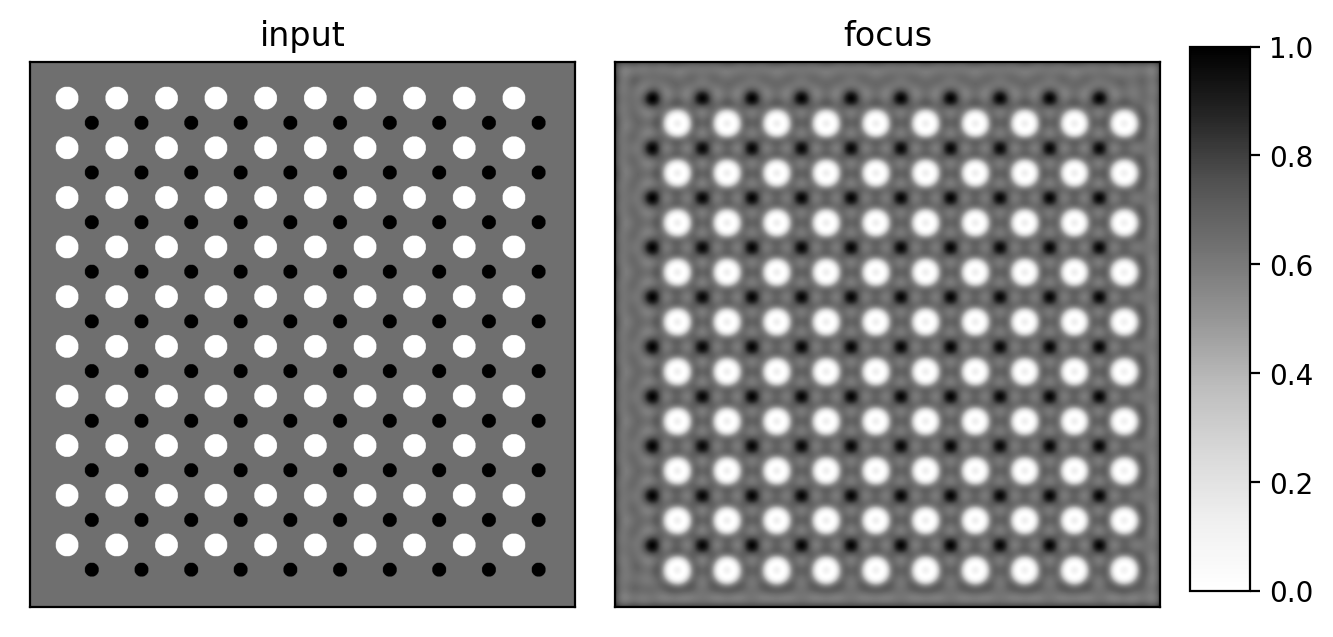

In [88]:
saveplot=True
cmap='Greys'
fig,axes = plt.subplots(ncols=len(labels),sharey=True,dpi=200)
for l,field,z2,ax in zip(
        labels,[field0,focal_field],[0]+zvals,axes):
        I2_xy = conjugate(field)*field
        if z2 == f2 or z2 == 0:
            I2xy_max = amax(I2_xy)
        I2_xy /= I2xy_max
        I2_xy = real(I2_xy)

        # plot
        if plot:
            scl = 1e6
            ax.set_title(l)
#             ax.set_aspect('equal')
            cax = ax.imshow(I2_xy,cmap=cmap,extent=[-x2pts[0]*scl,x2pts[0]*scl,-x2pts[0]*scl,x2pts[0]*scl])
            cax.set_norm(colors.Normalize(vmin=0, vmax=1))
        
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
#             if l == labels[-2]:
#                 fig.colorbar(cax)
        
        if savedata:
            fname = f'{name}_{l}_{int(time())}.csv'
            filepath = os.path.join(imagedir,fname)
            soln_to_csv(filepath, I2_xy, labels=False, metastr=metadata)
            
cm = plt.axes([1, 0.18, 0.05, 0.68])
fig.colorbar(cax,cax=cm)
plt.tight_layout()

# plt.savefig('bright_dark_mask_input_focus_abright_120um_adark_75um.svg',bbox_inches='tight')

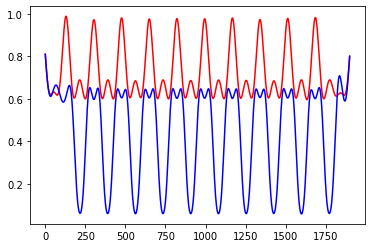

In [90]:
i2xy = abs(focal_field)**2
i2xy /= amax(i2xy)
plt.plot(i2xy[:,pts//2+42],color='red')
plt.plot(i2xy[:,pts//2+100],color='blue')
# plt.savefig('bright_dark_mask_focus_profiles_abright_120um_adark_75um.svg',bbox_inches='tight')

In [91]:
bdual

0.0020531109836319492

In [ ]:
b

In [91]:
# xout,yout = soln_from_csv('rs_bright_f1_150mm_f2_5mm_a_100um.csv',labels=False)
# xout,yout = soln_from_csv('rs_dark_f1_150mm_f2_5mm_a_100um.csv',labels=False)

C:\Users\prest\.virtualenvs\fourier-optics-rBKOIr-o\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


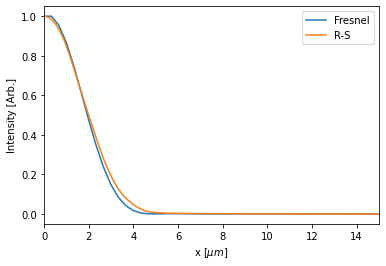

In [93]:
# comparison of bright trap with R-S calculation

i2xy = abs(focal_field)**2
# plt.imshow(i2xy/amax(i2xy),cmap='inferno',extent=array([x2pts[0],x2pts[-1],x2pts[0],x2pts[-1]])*1e6)
plt.plot(x2pts*1e6,i2xy[pts//2,:]/amax(i2xy),label='Fresnel')
plt.plot(xout,yout/max(real(yout)),label='R-S')
plt.xlabel('x [$\mu m$]')
plt.ylabel('Intensity [Arb.]')
plt.xlim((0,15))
plt.legend()
# plt.savefig('Fresnel_RS_compare_bright_f1_150mm_f2_5mm.png',bbox_inches='tight')

dark_trap_ta_pt29_vs_ta_0_d_4.3a.png


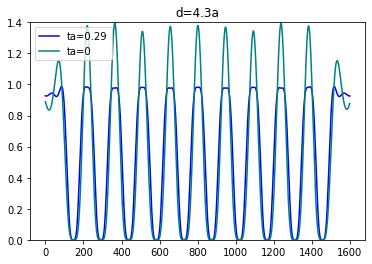

In [245]:
# comparison of dark traps with ta=0.287, ta=0

e1,e2 = focalfields
i1 = abs(e1)**2
i2 = abs(e2)**2
norm = amax(i1)
i1 /= norm
i2 /= norm
# plt.imshow(i1)
# plt.axhline(870)
plt.plot(i1[870,:],c='blue',label='ta=0.29')
plt.plot(i2[870,:],c='teal',label='ta=0')
plt.title(f'd={d/a:.1f}a')
plt.ylim((0,1.4))
plt.legend()
fname = f'dark_trap_ta_pt29_vs_ta_0_d_{d/a:.1f}a.png'
print(fname)
plt.savefig(fname,bbox_inches='tight')

In [246]:
1.17/1.07

1.0934579439252334

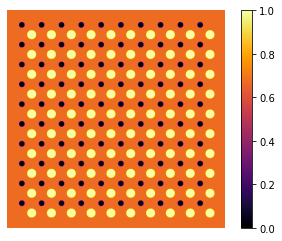

In [14]:
# i2xy = abs(focal_field)**2
i2xy = abs(field0)**2

i2xy /= amax(i2xy)
plt.imshow(i2xy,cmap='inferno')#,extent=array([x2pts[0],x2pts[-1],x2pts[0],x2pts[-1]])*1e6)
# plt.xlabel('x [$\mu m$]')
# plt.ylabel('y [$\mu m$]')
# plt.title('$t_a=0$')
plt.colorbar()

#for dual species
# plt.axhline(-10,color='red')
# plt.axhline(-30,color='blue')
# plt.axhline(pts//2+45,color='red')
# plt.axhline(pts//2+100,color='blue')

#for single
# plt.axhline(456)

plt.axis('off')

# plt.savefig('bright_dark_mask_ta_0_tb_pt82_10x10_f1_500mm_f2_50mm.png',bbox_inches='tight')

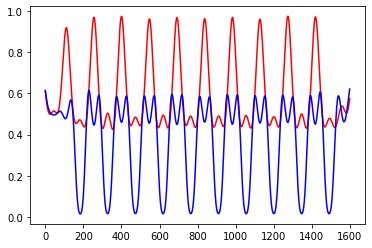

In [206]:
plt.plot(i2xy[:,pts//2+42],color='red')
plt.plot(i2xy[:,pts//2+100],color='blue')

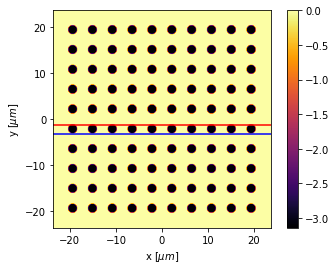

In [390]:
e0xy = field0
plt.imshow(angle(e0xy),cmap='inferno',extent=array([x2pts[0],x2pts[-1],x2pts[0],x2pts[-1]])*1e6)
plt.xlabel('x [$\mu m$]')
plt.ylabel('y [$\mu m$]')
# plt.title('$t_a=0$')
plt.colorbar()
plt.axhline(-1.2,color='red')
plt.axhline(-3.2,color='blue')
# plt.savefig('bright_dark_ta_0_tb_pt7_10x10_f1_500mm_f2_5mm_redblueline.svg',bbox_inches='tight')

(0.0, 1.1)

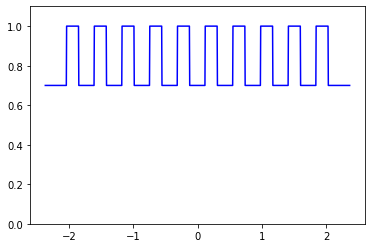

In [391]:
# transmission amplitude of the mask (|ta|)
# i1 = abs(field0[475])
i1 = abs(field0[455])
plt.plot(x0pts*1e3,i1/max(i1),color='blue')#,lw=4)
i1 = abs(field0[435])
# plt.plot(x0pts*1e3,i1/max(i1),color='red')#,lw=4)
plt.ylim((0,1.1))
# plt.xlim((1,4))
# plt.savefig('bright_dark_ta_0_tb_pt7_10x10_f1_500mm_f2_5mm_profiles.svg',bbox_inches='tight')

In [336]:
angle(array([exp(1j*x) for x in [0,pi/2,pi,3*pi/2,2*pi]]))

array([ 0.00000000e+00,  1.57079633e+00,  3.14159265e+00, -1.57079633e+00,
       -2.44929360e-16])

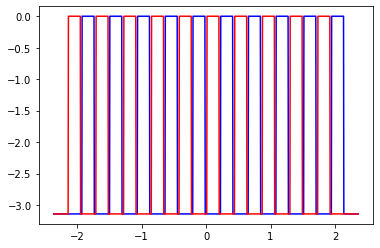

In [383]:
# mask phase (arg(mask))
i1 = angle(field0[475])
plt.plot(x0pts*1e3,i1,color='blue')#,lw=4)
i1 = angle(field0[435])
plt.plot(x0pts*1e3,i1,color='red')#,lw=4)
# plt.ylim((0,1.1))
# plt.xlim((1,4))
plt.savefig('bright_dark_ta_0_tb_pt7_10x10_f1_500mm_f2_5mm_profiles.svg',bbox_inches='tight')

(0.0, 1.1)

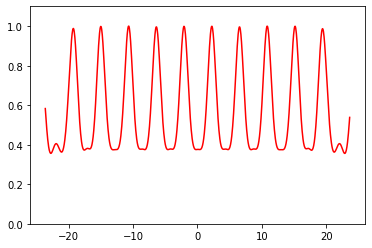

In [405]:
# i1 = abs(focal_field[475])**2
i1 = abs(focal_field[455])**2
# plt.plot(x2pts*1e6,i1/max(i1),color='blue')#,lw=4)
# i1 = abs(focal_field[435])**2
plt.plot(x2pts*1e6,i1/max(i1),color='red')#,lw=4
plt.ylim((0,1.1))
# plt.xlim((1,4))
# plt.savefig('bright_dark_ta_0_tb_pt7_10x10_f1_500mm_f2_5mm_profiles.svg',bbox_inches='tight')

(0.0, 1.1)

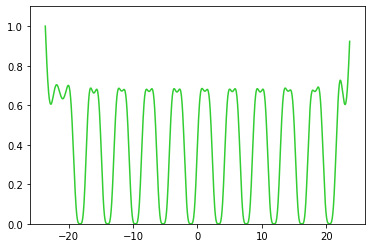

In [281]:
i2xy = abs(focal_field[475])**2
plt.plot(x2pts*1e6,i2xy/max(i2xy),color='limegreen')#,lw=4)
plt.ylim((0,1.1))
# plt.xlim((1,4))
# plt.savefig('ta0_10x10_f1_500mm_f2_5mm_profile.svg',bbox_inches='tight')

(0.0, 2.0)

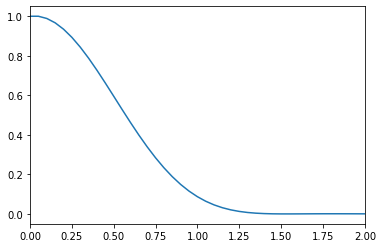

In [188]:
# i2xy = abs(focal_field[pts//2])**2
plt.plot(x2pts*1e6,i2xy/max(i2xy))
# plt.ylim((0,0.0025))
plt.xlim((0,2))

(400.0, 600.0)

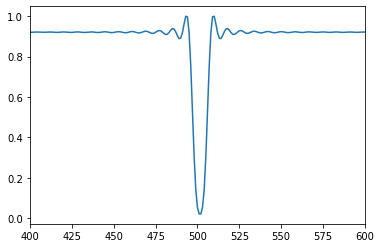

In [101]:
i2xy = abs(focal_field[pts//2])**2
plt.plot(i2xy/max(i2xy))
plt.xlim((400,600))

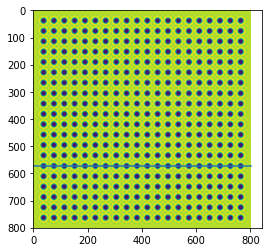

In [10]:
yb = 574
yd = 625
plt.show()
plt.imshow(abs(focal_field)**2)
plt.plot([0,pts],[yb,yb],label='bright')
# plt.plot([0,pts],[yd,yd],label='red')
plt.show()

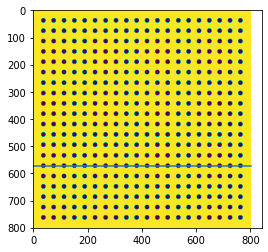

In [21]:
yb = 574
yd = 625
plt.show()
plt.imshow(abs(field0)**2)
plt.plot([0,pts],[yb,yb],label='bright')
# plt.plot([0,pts],[yd,yd],label='red')
plt.show()

No handles with labels found to put in legend.


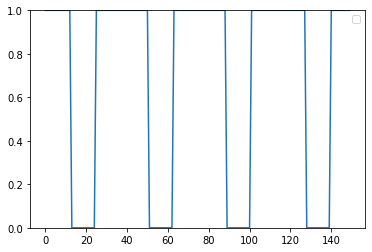

In [19]:
plt.plot(abs(field0[yb+3,400:550])**2/amax(abs(field0)**2))#,label=i)
# plt.plot(abs(focal_field[yd,])**2/amax(abs(focal_field)**2))
plt.ylim((0,1))
plt.legend()

In [157]:
sqrt(.5)

0.7071067811865476

In [158]:
sqrt(2)/2

0.7071067811865476

(0.0, 1.0)

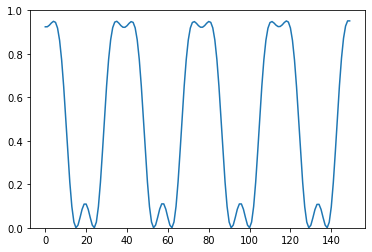

In [33]:
# for i in range(5):
plt.plot(abs(focal_field[yb,400:550])**2/amax(abs(focal_field)**2))#,label=i)
# plt.plot(abs(focal_field[yd,])**2/amax(abs(focal_field)**2))
plt.ylim((0,1))
# plt.legend()

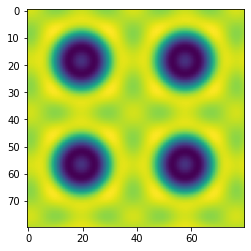

In [31]:
plt.imshow(abs(focal_field[yb-20:yb+60,400:480])**2/amax(abs(focal_field)**2))

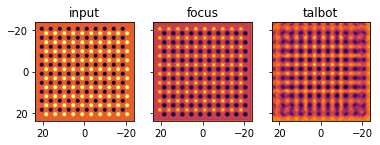

In [70]:
fig,axes = plt.subplots(ncols=3,sharey=True)#,dpi=100)

for l,field,z2,ax in zip(
        labels,[field0,focal_field,talbot_field],[0]+zvals,axes):
        I2_xy = conjugate(field)*field
        if z2 == f2 or z2 == 0:
            I2xy_max = amax(I2_xy)
        I2_xy /= I2xy_max
        I2_xy = real(I2_xy)

        # plot
        if plot:
            scl = 1e6
            ax.set_title(l)
#             ax.set_aspect('equal')
            cax = ax.imshow(I2_xy,cmap=cmap,extent=[-x2pts[0]*scl,x2pts[0]*scl,-x2pts[0]*scl,x2pts[0]*scl])
            cax.set_norm(colors.Normalize(vmin=0, vmax=1))    
  

In [48]:
x2pts[0],x2pts[-1]

(-2.362849999999996e-05, 2.362849999999996e-05)

## parameter scan
one basic mask configuration, but scan over a particular parameter, e.g. iris radius b

In [34]:
## physics and lens params
lmbda = 8.25e-7
k = 2*pi/lmbda
f1 = .5 # lens focal length [m]
f2 = 0.005
A0 = 1 # input field amplitude

## input mask grid params
xnum = ynum = 20 # number of grid points in each dimension
pts = 801 ##1100 # grid mesh is pts x pts

# Gaussian beam array object.
param_names = ['type','a1','tb1','ta1','dx','dy','a2','tb2','phi_std','pos_std']
gba = namedtuple('gba',param_names,defaults=[None,None,None,None]) 

In [35]:
## the Gaussian beams arrays to generate

a = 1e-4
d = 4.3*a
ta1 = 0 # spot transmittivity for a dark mask/ reflectivity if using a DMD
# tb1 = 1 # background transmittivity/ reflectivity if using a DMD

configurations = [
                    gba('dmd',a,tb1,ta1,d,d)
                ]

# custom colormap
n_bin = 100
# colorlist = [(0, 0, 0), (1, 0, 0)]  # black to red
# colorlist = [(0, 0, 0),(249/255,15/255,15/255),(249/255, 239/255, 239/255)] # black-red-pink
# colorlist = [(0, 0, 0),(169/255,15/255,15/255),(249/255, 75/255, 75/255)] # black-red-red2
# colorlist = [(0, 0, 0),(169/255,15/255,15/255),(249/255, 75/255, 75/255)] # black-red-red3

# cmap = LinearSegmentedColormap.from_list('my_cmap', colorlist, N=n_bin)
cmap = 'jet'

In [38]:
b = f1*3.8317/(a*k)
print(b)
steps = linspace(0.8*b,1.2*b,5)
steps

0.0025155652312115135


array([0.00201245, 0.00226401, 0.00251557, 0.00276712, 0.00301868])

In [67]:
## scan the iris size

plot=False
savedata=False

labels = ['input','focus','talbot'] # output axial plane

b0 = f1*3.8317/(a*k)
bsteps = linspace(0.5*b0,1*b0,10)
    
focal_soln = []

for i,b in enumerate(bsteps):
    
    # extract the array params
    name,a1,tb1,ta1,dx,dy,a2,ta2,phi_std,pos_std = [
        getattr(cfg, attr) for attr in param_names]

    # calculate the Talbot lengths
    Lx2 = f2*dx/f1 # output array periodicity
    Ly2 = f2*dy/f1
    zTalbotx = 2*Lx2**2/lmbda 
    zTalboty = 2*Ly2**2/lmbda
#     b = f1*3.8317/(a1*k) # fourier plane filter radius
        
    # create the mask
    
    if name == 'bright_dark':
        
        mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                               phi_std=phi_std, pos_std=pos_std, 
                               aperture=ta1, plate=tb1)
        
        # make a plate with 0s in the background and spots = -tb1, 
        # so adding this to the plate we just made will complete the 
        # bright-dark mask
        phi_std=None # [rad]
        pos_std=None
        t12 = 0 # plate transmissivity
        mask2, x0pts, w = spot_mask(xnum, ynum, a2, dx, dy, pts, 
            phi_std=phi_std, pos_std=pos_std, aperture=1-tb1, plate=t12)

        # need to offset mask2
        offset_pts= int(pts/(xnum+1)/2)
        mask2_offset = zeros((pts,pts),complex)
        for i in range(pts):
            for j in range(pts):
                if i + offset_pts < pts and j + offset_pts < pts: 
                    mask2_offset[i + offset_pts,j + offset_pts] = mask2[i,j]
        
        # offset the total mask to be more centered now
        mask_total = mask + mask2_offset
        offset_final_pts = int(offset_pts/2)
        mask_total_offset = full((pts,pts),tb1,complex)
        for i in range(pts):
            for j in range(pts):
                if i - offset_pts > 0 and j - offset_pts > 0: 
                    mask_total_offset[i - offset_final_pts,j - offset_final_pts] = mask_total[i,j]
        
        mask = mask_total_offset
#         b = f1*3.8317/(max(a1,a2)*k)
        
        print(f'b={b:0.6f}, a_dark={a1}, a_bright={a2}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
        print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
        
    else:
        
        mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                               phi_std=phi_std, pos_std=pos_std, 
                               aperture=ta1, plate=tb1)
        
        print(f'b={b:0.6f}, a={a1}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
        print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
        
    field0 = mask
    
    # SAVE THE INPUT MASK
        
    #todo
        
    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding = pts//2 # int(3*pts/2) #TODO set
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding, masked=False,
                              padval=1,logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    padding = pts//2

    # axial output planes to probe
    zvals = [f2, f2 + min(zTalbotx, zTalboty)]

    for z2 in zvals: 

        field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                                 logging=False)

        if z2 == f2:
            focal_field = field2
            focal_soln.append(focal_field)
        else:
            talbot_field = field2
           
    if plot:
        fig,axes = plt.subplots(ncols=3,sharey=True,dpi=100)

    metadata=f"lambda={lmbda}, f1={f1}, f2={f2}, xnum={xnum}, ynum={ynum}, a1={a1}, dx={dx}, \
        dy={dy}, b={b}, pts={pts}, phi_std={phi_std}, pos_std={pos_std}, \
        ta1={ta1}, tb1={tb1}, a2={a2}, ta2={ta2}, zTalbotx={zTalbotx}, \
        zTalboty={zTalboty}"
    
    for l,field,z2,ax in zip(
        labels,[field0,focal_field,talbot_field],[0]+zvals,axes):
        I2_xy = conjugate(field)*field
        if z2 == f2 or z2 == 0:
            I2xy_max = amax(I2_xy)
        I2_xy /= I2xy_max
        I2_xy = real(I2_xy)

        # plot
        if plot:
            scl = 1e6
            ax.set_title(l)
#             ax.set_aspect('equal')
            cax = ax.imshow(I2_xy,cmap=cmap,extent=[-x2pts[0]*scl,x2pts[0]*scl,-x2pts[0]*scl,x2pts[0]*scl])
            cax.set_norm(colors.Normalize(vmin=0, vmax=1))
            if l == labels[-1]:
                fig.colorbar(cax)
        
        if savedata:
            fname = f'{name}_{l}_{int(time())}.csv'
            filepath = os.path.join(imagedir,fname)
            soln_to_csv(filepath, I2_xy, labels=False, metastr=metadata)
            
print(f"step {i} completed")

b=0.001258, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045
b=0.001398, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045
b=0.001537, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045
b=0.001677, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045
b=0.001817, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045
b=0.001957, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045
b=0.002096, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045
b=0.002236, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045
b=0.002376, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045
b=0.002516, a=0.0001, dx=0.00043, dy=0.00043, xnum=20, ynum=20
zTalbotx=0.000045, zTalboty=0.000045


In [68]:
bsteps/b0

array([0.5       , 0.55555556, 0.61111111, 0.66666667, 0.72222222,
       0.77777778, 0.83333333, 0.88888889, 0.94444444, 1.        ])

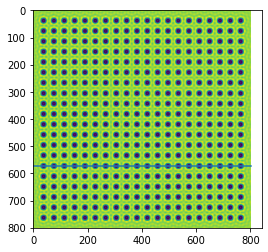

In [58]:
yb = 574
yd = 625
plt.show()
plt.imshow(abs(focal_field)**2)
plt.plot([0,pts],[yb,yb],label='bright')
# plt.plot([0,pts],[yd,yd],label='red')
plt.show()

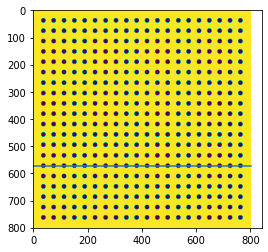

In [59]:
yb = 574
yd = 625
plt.show()
plt.imshow(abs(field0)**2)
plt.plot([0,pts],[yb,yb],label='bright')
# plt.plot([0,pts],[yd,yd],label='red')
plt.show()

No handles with labels found to put in legend.


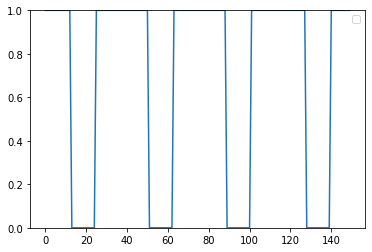

In [44]:
plt.plot(abs(field0[yb+3,400:550])**2/amax(abs(field0)**2))#,label=i)
# plt.plot(abs(focal_field[yd,])**2/amax(abs(focal_field)**2))
plt.ylim((0,1))
plt.legend()

In [61]:
steps/b

array([0.66666667, 0.75      , 0.83333333, 0.91666667, 1.        ])

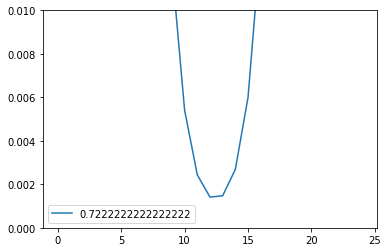

In [99]:
# j = 115
# for step,field in zip(bsteps,focal_soln):
#     plt.plot(abs(field[yb,445+j:470+j])**2/amax(abs(field)**2),label=step/b0)
#     # plt.plot(abs(focal_field[yd,])**2/amax(abs(focal_field)**2))
    
field = focal_soln[4]
step = bsteps[4]
plt.plot(abs(field[yb,445:470])**2/amax(abs(field)**2),label=step/b)
# field = focal_soln[-1]
# step = bsteps[-1]
# plt.plot(abs(field[yb,400:550])**2/amax(abs(field)**2),label='b')#step/b)

plt.ylim((0,.01))
plt.legend()

Text(0, 0.5, 'log(trap center intensity)')

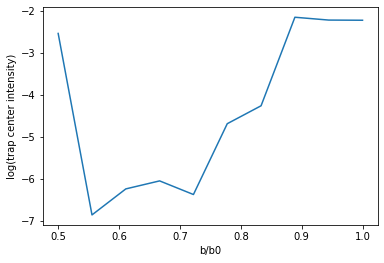

In [96]:
centers = [abs(field[yb,572])**2/amax(abs(field)**2) for field in focal_soln]
plt.plot(bsteps/b0,np.log(centers))
plt.xlabel("b/b0")
plt.ylabel("log(trap center intensity)")

In [56]:
steps/b

array([0.8, 0.9, 1. , 1.1, 1.2])

In [55]:
steps = linspace(0.8*b,1.2*b,5)
steps/b

array([0.8, 0.9, 1. , 1.1, 1.2])

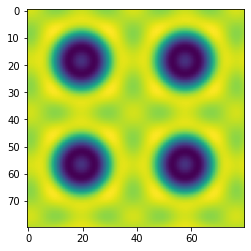

In [31]:
plt.imshow(abs(focal_field[yb-20:yb+60,400:480])**2/amax(abs(focal_field)**2))

## XZ Plots
Intensity slice in x-z plane, where z is the propagation axis

In [208]:
## physics and lens params
lmbda = 8.08e-7
k = 2*pi/lmbda
f1 = .5 # lens focal length [m]
f2 = 0.005
A0 = 1 # input field amplitude

## input mask grid params
xnum = ynum = 1 # number of grid points in each dimension
a = 1e-4
d = 40*a # set to much larger than a for 1 aperture
ta1 = 0.287119 # spot transmittivity for a dark mask
tb1 = 1 # background transmittivity
pts = 1201 ##1100 # grid mesh is pts x pts
padding = pts # int(3*pts/2) #TODO set

# calculate the Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda
zTalboty = 2*Ly2**2/lmbda

numsteps = 60 # zsteps to compute.
z2steps = lambda zT: linspace(0,0.00005,numsteps)

# Gaussian beam array object.
param_names = ['type','a1','tb1','ta1','b','dx','dy','a2','tb2','phi_std','pos_std']
gba = namedtuple('gba',param_names,defaults=[None,None,None,None])

In [209]:
w0 = 0.943120*a*f2/f1 # estimated quadratic fit waist
zR = pi*w0**2/lmbda
zR

3.458377693193521e-06

In [210]:
## the Gaussian beams arrays to generate

b0 = f1*3.8317/(a*k) # fourier plane filter radius

configurations = [
#                     gba('dmd',a,1,0,b0,d,d)
                    gba('bright',a,0,1,b0,d,d),
#                     gba('bright_phases',a,0,1,b0,d,d,phi_std=0.2),
#                     gba('bright_pos',a,0,1,b0,d,d,pos_std=0.2*a),
#                     gba('bright_asym',a,0,1,b0,d,1.22*d),
                    gba('dark',a,1,0.287119,b0,d,d),
                    gba('dark',a,1,0,b0*2.40483/3.8317,d,d),
#                     gba('dark',a,1,0,b0*5.52008/3.8317,d,d)
#                     gba('dark_pos',a,tb1,ta1,b0,d,d,pos_std=0.2*a),
#                     gba('dark_asym',a,tb1,ta1,b0,d,1.22*d),
#                     gba('bright_dark',a,0.77,0.77*ta1,b0,d,d,a2=a)
                ] 

b=0.002464, a=0.0001, dx=0.004, dy=0.004, xnum=1, ynum=1
zTalbotx=0.003960, zTalboty=0.003960
obtained normalization factor
z step 0 completed
z step 1 completed
z step 2 completed
z step 3 completed
z step 4 completed
z step 5 completed
z step 6 completed
z step 7 completed
z step 8 completed
z step 9 completed
z step 10 completed
z step 11 completed
z step 12 completed
z step 13 completed
z step 14 completed
z step 15 completed
z step 16 completed
z step 17 completed
z step 18 completed
z step 19 completed
z step 20 completed
z step 21 completed
z step 22 completed
z step 23 completed
z step 24 completed
z step 25 completed
z step 26 completed
z step 27 completed
z step 28 completed
z step 29 completed
z step 30 completed
z step 31 completed
z step 32 completed
z step 33 completed
z step 34 completed
z step 35 completed
z step 36 completed
z step 37 completed
z step 38 completed
z step 39 completed
z step 40 completed
z step 41 completed
z step 42 completed
z step 43 completed
z step

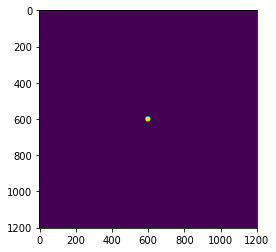

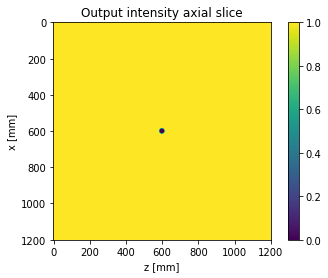

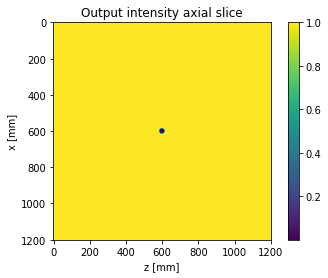

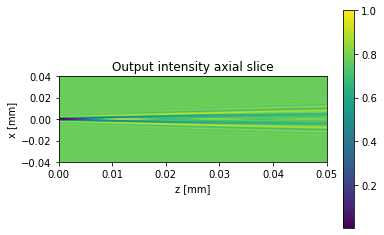

In [211]:
plot=True
savedata=True

xslice = pts//2
xyslices = []

for j,cfg in enumerate(configurations):
    
    # extract the array params
    name,a1,tb1,ta1,b,dx,dy,a2,ta2,phi_std,pos_std = [
        getattr(cfg, attr) for attr in param_names]

    # calculate the Talbot lengths
    Lx2 = f2*dx/f1 # output array periodicity
    Ly2 = f2*dy/f1
    zTalbotx = 2*Lx2**2/lmbda
    zTalboty = 2*Ly2**2/lmbda
        
    # create the mask
    mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                           phi_std=phi_std, pos_std=pos_std, 
                           aperture=ta1, plate=tb1)

    print(f'b={b:0.6f}, a={a1}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
    print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
     
    field0 = mask
    if not xnum % 2: # dumb workaround for off-centered masks 
        mask=mask[:-1,:-1]
    plt.imshow(real(field0))
    
    # axial position steps after lens f2
    zTalbot = max(zTalbotx,zTalboty)
    z2 = f2
#     dz2_steps = linspace(-zTalbot*depth,zTalbot*depth,numsteps)
    dz2_steps = z2steps(zTalbot)
    I2max = 1
    
    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding,masked=False,
                              padval=1,logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)

    slices_soln = empty((pts,numsteps),dtype=float)
    t0 = time()
    for i,dz2 in enumerate(dz2_steps):

        # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
        rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
        field2,x2pts = lens_xform(z2+dz2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                                  logging=False)

        I2_xy = abs(field2)**2
        if dz2 == 0:
            I2max = amax(I2_xy)
            xpts = x2pts
            print("obtained normalization factor")
        slices_soln[:,i] = I2_xy[:,xslice]/I2max
        xyslices.append(I2_xy/I2max)
        print(f"z step {i} completed")
           
    metadata=f"lambda={lmbda}, f1={f1}, f2={f2}, xnum={xnum}, ynum={ynum}, a1={a1}, dx={dx}, \
        dy={dy}, pts={pts}, phi_std={phi_std}, pos_std={pos_std}, \
        ta1={ta1}, tb1={tb1}, a2={a2}, ta2={ta2}, zTalbotx={zTalbotx}, \
        zTalboty={zTalboty}"
    
    if amax(slices_soln) != 1:
        slices_soln /= amax(slices_soln)

    # plot
    if plot:
        fig,ax = plt.subplots()
        mmscl = 1e3
        M = f2/f1
        cax = ax.imshow(slices_soln, extent=[dz2_steps[0]*mmscl,dz2_steps[-1]*mmscl,-w*mmscl*M,w*mmscl*M])
        ax.set_xlabel("z [mm]")
        ax.set_ylabel("x [mm]")
        ax.set_title("Output intensity axial slice")

        # cax.set_norm(colors.Normalize(vmin=0, vmax=1))
        ax.set_aspect(0.2)
        cbar = fig.colorbar(cax)   

    if savedata:
        fname = f'{name}_axial_{int(time())}.csv'
        filepath = os.path.join(imagedir,fname)
        soln_to_csv(filepath, slices_soln, labels=False, metastr=metadata)
            
    print(f"cfg step {j} completed")

In [212]:
x2pts[0],x2pts[-1],len(x2pts)

(-3.996669442131373e-05, 3.996669442131373e-05, 1201)

(0.0, 1.0)

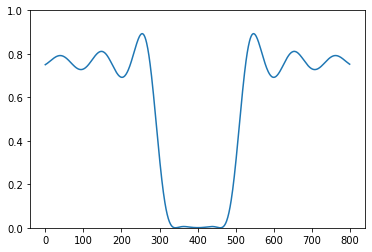

In [78]:
plt.plot(slices_soln[:,0])
plt.ylim((0,1))

In [83]:
xpts[0],xpts[-1]

(-4.2946249999998884e-05, 4.2946249999998884e-05)

## T=0.49 mask
the real mask we have in the lab. four lens transformations, to have the same field we get at the Thorlabs CCD.

the output field is not as expected, so i think there may be a scaling error somewhere, e.g. how the zsteps are set

In [199]:
## physics and lens params
lmbda = 8.08e-7
k = 2*pi/lmbda
f1 = 0.25 # 
f2 = 0.075
f3 = 0.06
f4 = 0.05 # in the lab, this is effective f1 to the intermediate CCD
A0 = 1 # input field amplitude

## input mask grid params
xnum = ynum = 10 # number of grid points in each dimension
dx = dy = 4.3e-4
pts = 1001 # grid mesh is pts x pts
phi = 140 # phase difference between mask background and partially reflective apertures

# calculate the Talbot lengths
Lx2 = (f2/f1)*(f3/f4)*dx # output array periodicity
Ly2 = (f2/f1)*(f3/f4)*dy
zTalbotx = 2*Lx2**2/lmbda
zTalboty = 2*Ly2**2/lmbda

numsteps = 19 # zsteps to compute.

w0 = 2.4e-6 # estimated quadratic fit waist
zR = pi*w0**2/lmbda

z2steps = lambda zT: linspace(0,0.0035,numsteps)
b = 0.5e-3

# Gaussian beam array object.
param_names = ['type','a1','tb1','ta1','dx','dy','a2','tb2','phi_std','pos_std']
gba = namedtuple('gba',param_names,defaults=[None,None,None,None])

In [200]:
## the Gaussian beam arrays to generate

a = 1e-4 # mask aperture radius
d = 4.3*a # mask aperture period
ta1 = sqrt(0.49) # aperture transmittivity for a dark mask
tb1 = 1 # background transmittivity

configurations = [
                    gba('dark',a,tb1,ta1,d,d)
                 ]

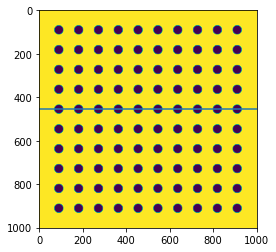

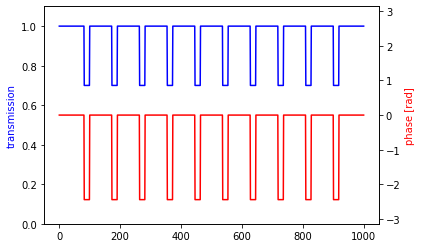

In [201]:
for cfg in configurations:
    name,a1,tb1,ta1,dx,dy,a2,ta2,phi_std,pos_std = [
            getattr(cfg, attr) for attr in param_names]

    mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                           phi_std=phi_std, pos_std=pos_std, 
                           aperture=ta1, plate=tb1)
    if phi != 0:
        complement, _, _ = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)
        spot_phases, _, _ = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
        spot_phases *= exp(-1j*phi*pi/180)
        phase_mask = spot_phases + complement
        mask *= phase_mask
    field0 = mask

    mask = real(field0)
    plt.imshow(mask)
    # mask = mask[1:,1:]
    plt.imshow(mask)
    # plt.plot([0,mask.shape[0]-1],[(mask.shape[1]-1)/2,(mask.shape[1]-1)/2])
    # plt.plot([(mask.shape[0]-1)/2,(mask.shape[0]-1)/2],[0,mask.shape[1]-1])
    xslice = 453
    plt.axhline(xslice)

    fig,ax1 = plt.subplots()
    ax1.plot(range(pts), abs(field0[800,:]),color='blue')
    ax1.set_ylabel("transmission",color='blue')
    ax1.set_ylim((0,1.1))

    ax2 = ax1.twinx()
    ax2.plot(range(pts), angle(field0[800,:]),color='red')
    ax2.set_ylabel("phase [rad]",color='red')
    ax2.set_ylim((-pi,pi))

b=0.000500, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.041191, zTalboty=0.041191
obtained normalization factor
z step 0 completed
z step 1 completed
z step 2 completed
z step 3 completed
z step 4 completed
z step 5 completed
z step 6 completed
z step 7 completed
z step 8 completed
z step 9 completed
z step 10 completed
z step 11 completed
z step 12 completed
z step 13 completed
z step 14 completed
z step 15 completed
z step 16 completed
z step 17 completed
z step 18 completed
wrote data to .\paper_data\dark_axial_1645822899.csv
cfg step 0 completed


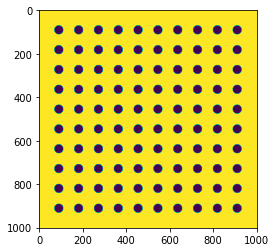

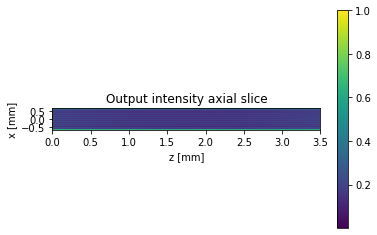

In [202]:
plot=True
padding = 3*pts//2
savedata=True

xyslices = []

for j,cfg in enumerate(configurations):
    
    # extract the array params
    name,a1,tb1,r1,dx,dy,a2,ta2,phi_std,pos_std = [
        getattr(cfg, attr) for attr in param_names]

    # calculate the Talbot lengths
    Lx2 = f2*dx/f1 # output array periodicity
    Ly2 = f2*dy/f1
    zTalbotx = 2*Lx2**2/lmbda
    zTalboty = 2*Ly2**2/lmbda
#     b = f1*3.8317/(a1*k) # fourier plane filter radius
        
    # create the mask
    mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                           phi_std=phi_std, pos_std=pos_std, 
                           aperture=ta1, plate=tb1)
    complement, _, _ = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)
    spot_phases, _, _ = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
    spot_phases *= exp(-1j*phi*pi/180)
    phase_mask = spot_phases + complement
    mask *= phase_mask

    print(f'b={b:0.6f}, a={a1}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
    print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
     
    field0 = mask
    if not xnum % 2: # dumb workaround for off-centered masks 
        mask=mask[:-1,:-1]
    plt.imshow(real(field0))
    
    # axial position steps after lens f2
    I2max = 1
    
    # FOURIER PLANE 1 -- propogate the field and apply a filter in the Fourier plane
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding,masked=False,
                              padval=1,logging=False)

    # IMAGE PLANE 1
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    field2,x2pts = lens_xform(f2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                                  logging=False)

    # FOURIER PLANE 2
    rr2 = sqrt(x2pts**2 + x2pts.reshape(-1,1)**2)
    field3,x3pts = lens_xform(f3,field2,b,f3,k,x2pts,rr2,padding,masked=False,
                                  logging=False)
    rr3 = sqrt(x3pts**2 + x3pts.reshape(-1,1)**2)    
        
    slices_soln = empty((pts,numsteps),dtype=float)
    t0 = time()
    for i,dz2 in enumerate(dz2_steps):

        # OUTPUT FIELD -- propagate field to the final imaging plane + dz2
        field4,x4pts = lens_xform(f4+dz2,field3,b,f4,k,x3pts,rr3,padding,masked=False,
                                  logging=False)

        if dz2 == 0:
            I2max = max(abs(field4[:,xslice])**2)
            Ixymax = amax(abs(field4)**2)
            print("obtained normalization factor")

        slices_soln[:,i] = abs(field4[:,xslice])**2/I2max
        xyslices.append(abs(field4)**2/Ixymax)
#         print(f"axial plane {i} completed")

        print(f"z step {i} completed")
           
    metadata=f"lambda={lmbda}, f1={f1}, f2={f2}, xnum={xnum}, ynum={ynum}, a1={a1}, dx={dx}, \
        dy={dy}, pts={pts}, phi_std={phi_std}, pos_std={pos_std}, \
        ta1={ta1}, tb1={tb1}, a2={a2}, ta2={ta2}, zTalbotx={zTalbotx}, \
        zTalboty={zTalboty}"
    
    if amax(slices_soln) != 1:
        slices_soln /= amax(slices_soln)

    # plot
    if plot:
        fig,ax = plt.subplots()
        mmscl = 1e3
        M = f2/f1
        cax = ax.imshow(slices_soln, extent=[dz2_steps[0]*mmscl,dz2_steps[-1]*mmscl,-w*mmscl*M,w*mmscl*M])
        ax.set_xlabel("z [mm]")
        ax.set_ylabel("x [mm]")
        ax.set_title("Output intensity axial slice")

        # cax.set_norm(colors.Normalize(vmin=0, vmax=1))
        ax.set_aspect(0.2)
        cbar = fig.colorbar(cax)   

    if savedata:
        fname = f'{name}_axial_{int(time())}.csv'
        filepath = os.path.join(imagedir,fname)
        soln_to_csv(filepath, slices_soln, labels=False, metastr=metadata)
            
    print(f"cfg step {j} completed")

## T=0.49 mask
the real mask we have in the lab

In [23]:
## physics and lens params
lmbda = 8.08e-7
k = 2*pi/lmbda
f1 = 0.5 # 
f2 = 0.05 #*0.05/0.06 # in the lab, this is effective f1 to the intermediate CCD
A0 = 1 # input field amplitude

## input mask grid params
xnum = ynum = 35 # number of grid points in each dimension
dx = dy = 4.3e-4
pts = 1101 # grid mesh is pts x pts
phi = 160 # phase difference between mask background and partially reflective apertures

# calculate the Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda
zTalboty = 2*Ly2**2/lmbda

numsteps = 19 # zsteps to compute.

w0 = 0.943120*a*f2/f1 # estimated quadratic fit waist
zR = pi*w0**2/lmbda

z2steps = lambda zT: linspace(0,0.0035,numsteps)
u = 0.4
bs = u*f1*3.8317/(a*k)

# Gaussian beam array object.
param_names = ['type','a1','tb1','ta1','dx','dy','a2','tb2','phi_std','pos_std']
gba = namedtuple('gba',param_names,defaults=[None,None,None,None])

In [16]:
## the Gaussian beam arrays to generate

a = 1e-4 # mask aperture radius
d = 4.3*a # mask aperture period
ta1 = 0.7 # aperture transmittivity for a dark mask
tb1 = 1 # background transmittivity

configurations = [
                    gba('dark',a,tb1,ta1,d,d)
                 ]

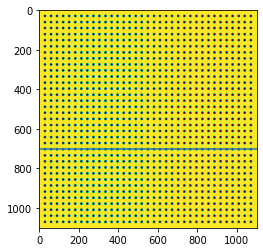

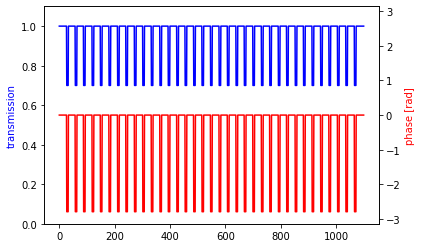

In [17]:
for cfg in configurations:
    name,a1,tb1,ta1,dx,dy,a2,ta2,phi_std,pos_std = [
            getattr(cfg, attr) for attr in param_names]

    mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                           phi_std=phi_std, pos_std=pos_std, 
                           aperture=ta1, plate=tb1)

    complement, _, _ = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)
    spot_phases, _, _ = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
    spot_phases *= exp(-1j*phi*pi/180)
    phase_mask = spot_phases + complement
    mask *= phase_mask
    field0 = mask

    mask = real(field0)
    plt.imshow(mask)
    # mask = mask[1:,1:]
    plt.imshow(mask)
    # plt.plot([0,mask.shape[0]-1],[(mask.shape[1]-1)/2,(mask.shape[1]-1)/2])
    # plt.plot([(mask.shape[0]-1)/2,(mask.shape[0]-1)/2],[0,mask.shape[1]-1])
    xslice = 700
    plt.axhline(xslice)

    fig,ax1 = plt.subplots()
    ax1.plot(range(pts), abs(field0[800,:]),color='blue')
    ax1.set_ylabel("transmission",color='blue')
    ax1.set_ylim((0,1.1))

    ax2 = ax1.twinx()
    ax2.plot(range(pts), angle(field0[800,:]),color='red')
    ax2.set_ylabel("phase [rad]",color='red')
    ax2.set_ylim((-pi,pi))

b=0.001000, a=0.0001, dx=0.00043, dy=0.00043, xnum=35, ynum=35
zTalbotx=0.004577, zTalboty=0.004577
obtained normalization factor
wrote data to .\paper_data\dark_axial_1647449513.csv
cfg step 0 completed


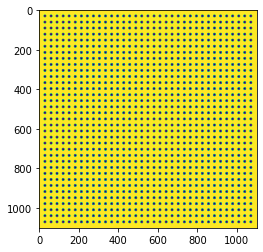

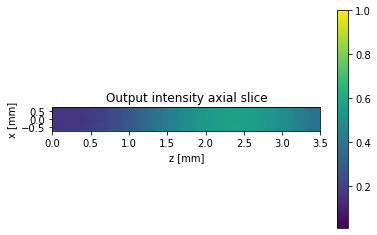

In [67]:
plot=True
padding = 3*pts//2
savedata=True

xyslices = []

for j,cfg in enumerate(configurations):
    
    # extract the array params
    name,a1,tb1,r1,dx,dy,a2,ta2,phi_std,pos_std = [
        getattr(cfg, attr) for attr in param_names]

    # calculate the Talbot lengths
    Lx2 = f2*dx/f1 # output array periodicity
    Ly2 = f2*dy/f1
    zTalbotx = 2*Lx2**2/lmbda
    zTalboty = 2*Ly2**2/lmbda
#     b = f1*3.8317/(a1*k) # fourier plane filter radius
        
    # create the mask
    mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                           phi_std=phi_std, pos_std=pos_std, 
                           aperture=ta1, plate=tb1)
    complement, _, _ = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=0, plate=1)
    spot_phases, _, _ = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1, plate=0)
    spot_phases *= exp(-1j*phi*pi/180)
    phase_mask = spot_phases + complement
    mask *= phase_mask

    print(f'b={b:0.6f}, a={a1}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
    print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
     
    field0 = mask
    if not xnum % 2: # dumb workaround for off-centered masks 
        mask=mask[:-1,:-1]
    plt.imshow(real(field0))
    
    # axial position steps after lens f2
    zTalbot = max(zTalbotx,zTalboty)
    z2 = f2
#     dz2_steps = linspace(-zTalbot*depth,zTalbot*depth,numsteps)
    dz2_steps = z2steps(zTalbot)
    I2max = 1
    
    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding,masked=False,
                              padval=1,logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)

    slices_soln = empty((pts,numsteps),dtype=float)
    t0 = time()
    for i,dz2 in enumerate(dz2_steps):

        # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
        rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
        field2,x2pts = lens_xform(z2+dz2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                                  logging=False)

        if dz2 == 0:
            I2max = max(abs(field2[:,xslice])**2)
            Ixymax = amax(abs(field2)**2)
            xpts = x2pts
            print("obtained normalization factor")
        slices_soln[:,i] = abs(field2[:,xslice])**2/I2max
        xyslices.append(abs(field2)**2/Ixymax)
        print(f"axial plane {i} completed")

        print(f"z step {i} completed")
           
    metadata=f"lambda={lmbda}, f1={f1}, f2={f2}, xnum={xnum}, ynum={ynum}, a1={a1}, dx={dx}, \
        dy={dy}, pts={pts}, phi_std={phi_std}, pos_std={pos_std}, \
        ta1={ta1}, tb1={tb1}, a2={a2}, ta2={ta2}, zTalbotx={zTalbotx}, \
        zTalboty={zTalboty}"
    
    if amax(slices_soln) != 1:
        slices_soln /= amax(slices_soln)

    # plot
    if plot:
        fig,ax = plt.subplots()
        mmscl = 1e3
        M = f2/f1
        cax = ax.imshow(slices_soln, extent=[dz2_steps[0]*mmscl,dz2_steps[-1]*mmscl,-w*mmscl*M,w*mmscl*M])
        ax.set_xlabel("z [mm]")
        ax.set_ylabel("x [mm]")
        ax.set_title("Output intensity axial slice")

        # cax.set_norm(colors.Normalize(vmin=0, vmax=1))
        ax.set_aspect(0.2)
        cbar = fig.colorbar(cax)   

    if savedata:
        fname = f'{name}_axial_{int(time())}.csv'
        filepath = os.path.join(imagedir,fname)
        soln_to_csv(filepath, slices_soln, labels=False, metastr=metadata)
            
    print(f"cfg step {j} completed")

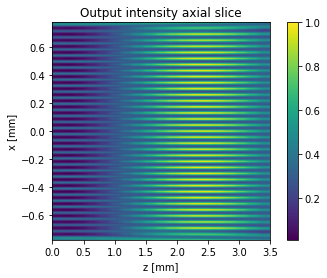

In [68]:
fig,ax = plt.subplots()
mmscl = 1e3
M = f2/f1
roi = 0
# cax = ax.imshow(slices_soln)
cax = ax.imshow(slices_soln[roi:pts-roi,:], extent=[dz2_steps[0]*mmscl,dz2_steps[-1]*mmscl,-w*mmscl*M,w*mmscl*M])
ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_title("Output intensity axial slice")

# cax.set_norm(colors.Normalize(vmin=0, vmax=1))
ax.set_aspect((dz2_steps[-1] - dz2_steps[0])/(2*w*M))
cbar = fig.colorbar(cax)

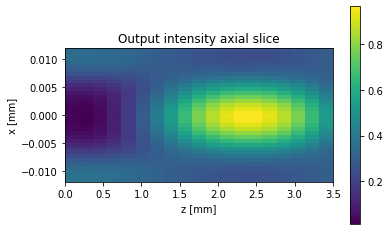

In [69]:
fig,ax = plt.subplots()
mmscl = 1e3
M = f2/f1
trim1=595
trim2=472
# cax = ax.imshow(slices_soln)
cax = ax.imshow(slices_soln[trim1:-trim2,:], extent=[dz2_steps[0]*mmscl,dz2_steps[-1]*mmscl,-w*mmscl*M*(pts-trim1-trim2)/(2*pts),w*mmscl*M*(pts-trim1-trim2)/(2*pts)])
ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_title("Output intensity axial slice")

# cax.set_norm(colors.Normalize(vmin=0, vmax=1))
ax.set_aspect((dz2_steps[-1] - dz2_steps[0])/(2*w*M*(pts-trim1-trim2)/pts))
cbar = fig.colorbar(cax)

In [42]:
slices_soln[trim1:-trim2,:].shape

(34, 19)

(array([0.00019444, 0.00038889, 0.00058333, 0.00077778, 0.00097222,
        0.00116667, 0.00136111, 0.00155556, 0.00175   , 0.00194444,
        0.00213889, 0.00233333, 0.00252778]),
 array([0.01502224, 0.0408047 , 0.0980485 , 0.18274581, 0.28894299,
        0.40915869, 0.53491028, 0.657312  , 0.76770249, 0.85825762,
        0.92254535, 0.95598325, 0.95616622]))

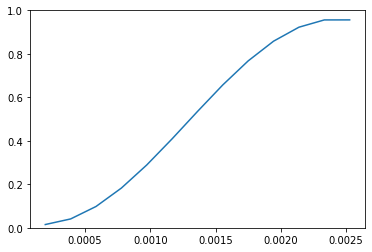

In [61]:
plt.plot(dz2_steps[1:-5],slices_soln[trim1:-trim2,:][16,1:-5])
plt.ylim((0,1))
dz2_steps[1:-5],slices_soln[trim1:-trim2,:][16,1:-5]

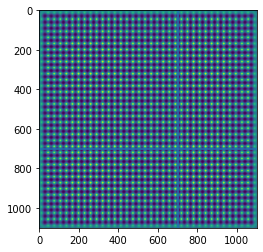

In [25]:
plt.imshow(xyslices[0])
plt.axvline(700)
plt.axhline(700)

(array([7.02997275e-05, 7.17057221e-05, 7.31117166e-05, 7.45177112e-05,
        7.59237057e-05, 7.73297003e-05, 7.87356948e-05, 8.01416894e-05,
        8.15476839e-05, 8.29536785e-05, 8.43596730e-05, 8.57656676e-05,
        8.71716621e-05, 8.85776567e-05, 8.99836512e-05, 9.13896458e-05,
        9.27956403e-05, 9.42016349e-05, 9.56076294e-05, 9.70136240e-05,
        9.84196185e-05, 9.98256131e-05, 1.01231608e-04, 1.02637602e-04]),
 array([0.24701732, 0.21539315, 0.18128151, 0.14724851, 0.11552849,
        0.08779616, 0.06503956, 0.04754862, 0.035015  , 0.02672049,
        0.02177698, 0.01937291, 0.01898123, 0.02049081, 0.02423764,
        0.03092969, 0.04147853, 0.05676759, 0.07739868, 0.10346329,
        0.13438197, 0.16884466, 0.2048685 , 0.23997038]))

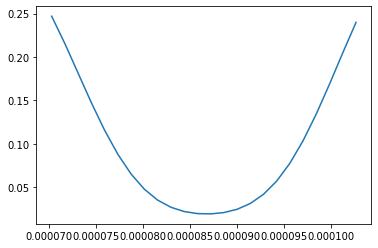

In [71]:
plt.plot(xpts[600:-477],xyslices[0][700,600:-477])
xpts[600:-477],xyslices[0][700,600:-477]

(0.0, 0.35)

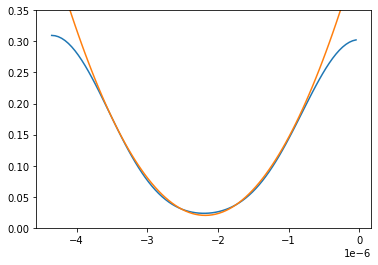

In [179]:
xpts = linspace(-w*M,w*M,pts)[408:500]
plt.plot(xpts,real(xyslices[1][xslice,408:500]))
plt.plot(xpts,0.28-0.26*(1 -2*((xpts+2.18e-6)/2.4e-6)**2))
plt.ylim(0,0.35)
# plt.plot(xpts,x)

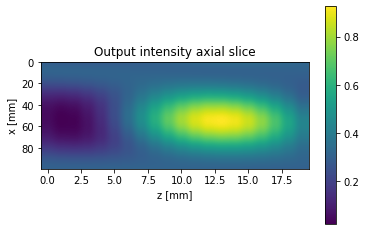

In [123]:
fig,ax = plt.subplots()
mmscl = 1e3
M = f2/f1
# cax = ax.imshow(slices_soln)
cax = ax.imshow(slices_soln[400:500,:])#, extent=[dz2_steps[0]*mmscl,dz2_steps[-1]*mmscl,-w*mmscl*M,w*mmscl*M])
ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_title("Output intensity axial slice")

# cax.set_norm(colors.Normalize(vmin=0, vmax=1))
# ax.set_aspect((dz2_steps[-1] - dz2_steps[0])/(2*w*M))
ax.set_aspect(0.08)
cbar = fig.colorbar(cax)

In [115]:
slices_soln[450:451].shape

(1, 20)

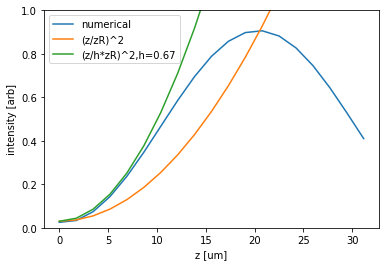

In [186]:
zpts = linspace(0,1.5*zR,numsteps)[:-1]
plt.plot(zpts*1e6,slices_soln[450:451].T[1:],label='numerical')
plt.plot(zpts*1e6,(zpts/zR)**2+0.03,label='(z/zR)^2')
h = 0.67
plt.plot(zpts*1e6,(zpts/(h*zR))**2+0.03,label=f'(z/h*zR)^2,h={h}')
plt.xlabel("z [um]")
plt.ylabel("intensity [arb]")
plt.ylim((0,1))
plt.legend()
# plt.plot()

In [131]:
z2steps

<function __main__.<lambda>(zT)>

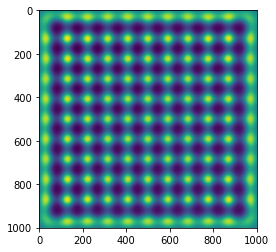

In [28]:
plt.imshow(real(xyslices[0]))

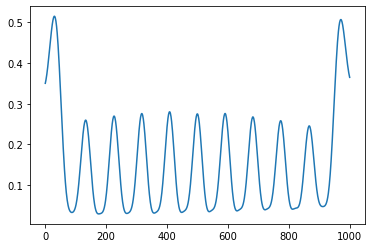

In [254]:
plt.plot(xyslices[0][453])

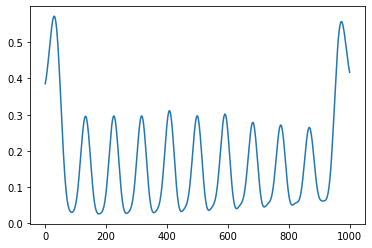

In [242]:
plt.plot(slices_soln[:,0])

In [201]:
 xslice

455

In [126]:
slices_soln.shape

(1001, 20)

## Paper

In [3]:
## physics and lens params
lmbda = 8.05e-7
k = 2*pi/lmbda
f1 = .5 # lens focal length [m]
f2 = .005
A0 = 1 # input field amplitude

## input mask grid params
xnum = ynum = 1 # number of grid points in each dimension
pts = 1001 # grid mesh is pts x pts
numsteps = 101 # zsteps to compute. should be odd number
depth = 1 # fraction of Talbot length to scan about either side z2 = f2
z2steps = lambda zT: linspace(0,zT*depth,numsteps)

# Gaussian beam array object.
param_names = ['type','a1','t1','r1','dx','dy','a2','r2','phi_std','pos_std']
gba = namedtuple('gba',param_names,defaults=[None,None,None,None]) 

In [4]:
## the Gaussian beams arrays to generate

a = 1e-4
d = 4*a
r = 1/sqrt(1.968)

configurations = [
                    gba('bright',a,0,0,d,d),
#                     gba('bright_phases',a,0,0,d,d,phi_std=0.2),
#                     gba('bright_pos',a,0,0,d,d,pos_std=0.2*a),
#                     gba('bright_asym',a,0,0,d,1.22*d),
                    gba('dark',a,1,r,d,d)
#                     gba('dark_pos',a,1,r,d,d,pos_std=0.2*a),
#                     gba('dark_asym',a,1,r,d,1.22*d),
#                     gba('bright_dark',a,0.8,r,d,d,a2=a,r2=0.5)
                ]      

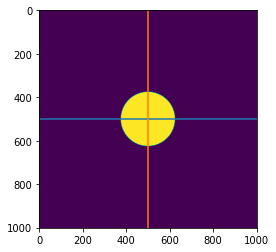

In [5]:
name,a1,t1,r1,dx,dy,a2,r2,phi_std,pos_std = [
        getattr(configurations[0], attr) for attr in param_names]
mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                               phi_std=phi_std, pos_std=pos_std, 
                               aperture=1-r1, plate=t1)
mask = real(mask)
plt.imshow(mask)
# mask = mask[1:,1:]
plt.imshow(mask)
# plt.xlim(((mask.shape[0]-1)/2),0)
# plt.ylim(((mask.shape[1]-1)/2),0)
plt.plot([0,mask.shape[0]-1],[(mask.shape[1]-1)/2,(mask.shape[1]-1)/2])
plt.plot([(mask.shape[0]-1)/2,(mask.shape[0]-1)/2],[0,mask.shape[1]-1])
# plt.plot(real(mask)[500,:])
# plt.plot([500,500],[1,0])
# plt.plot([500,610],[0.5,0.5])
# plt.plot([390,500],[0.5,0.5])
# plt.xlim(350,650)

In [6]:
k

0.0004

b=0.002455, a=0.0001, dx=0.0004, dy=0.0004, xnum=1, ynum=1
zTalbotx=0.000040, zTalboty=0.000040
obtained normalization factor
wrote data to .\paper_data\bright_axial_1626964002.csv
b=0.002455, a=0.0001, dx=0.0004, dy=0.0004, xnum=1, ynum=1
zTalbotx=0.000040, zTalboty=0.000040
obtained normalization factor
wrote data to .\paper_data\dark_axial_1626964104.csv
step 100 completed


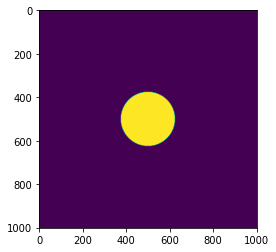

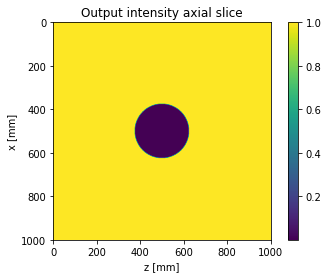

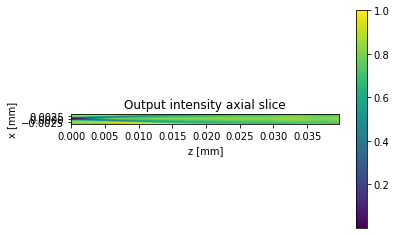

In [90]:
plot=True
# savedata=True

for i,cfg in enumerate(configurations):
    
    # extract the array params
    name,a1,tb1,r1,dx,dy,a2,ta2,phi_std,pos_std = [
        getattr(cfg, attr) for attr in param_names]

    # calculate the Talbot lengths
    Lx2 = f2*dx/f1 # output array periodicity
    Ly2 = f2*dy/f1
    zTalbotx = 2*Lx2**2/lmbda
    zTalboty = 2*Ly2**2/lmbda
    b = f1*3.8317/(a1*k) # fourier plane filter radius
        
    # create the mask
    
    if name == 'bright_dark':
        
        mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                               phi_std=phi_std, pos_std=pos_std, 
                               aperture=ta1, plate=tb1)
                
        # make a plate with 0s in the background and spots = -tb1, 
        # so adding this to the plate we just made will complete the 
        # bright-dark mask
        phi_std=None # [rad]
        pos_std=None
        t12 = 0 # plate transmissivity
        mask2, x0pts, w = spot_mask(xnum, ynum, a2, dx, dy, pts, 
            phi_std=phi_std, pos_std=pos_std, aperture=1-tb1, plate=t12)

        # need to offset mask2
        offset_pts= int(pts/(xnum+1)/2)
        mask2_offset = zeros((pts,pts),complex)
        for i in range(pts):
            for j in range(pts):
                if i + offset_pts < pts and j + offset_pts < pts: 
                    mask2_offset[i + offset_pts,j + offset_pts] = mask2[i,j]
        
        # offset the total mask to be more centered now
        mask_total = mask + mask2_offset
        offset_final_pts = int(offset_pts/2)
        mask_total_offset = full((pts,pts),tb1,complex)
        for i in range(pts):
            for j in range(pts):
                if i - offset_pts > 0 and j - offset_pts > 0: 
                    mask_total_offset[i - offset_final_pts,j - offset_final_pts] = mask_total[i,j]
        
        mask = mask_total_offset
        b = f1*3.8317/(max(a1,a2)*k)
        
        print(f'b={b:0.6f}, a_dark={a1}, a_bright={a2}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
        print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
        
    else:
        
        mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                               phi_std=phi_std, pos_std=pos_std, 
                               aperture=ta1, plate=tb1)
        
        print(f'b={b:0.6f}, a={a1}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
        print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
     
    field0 = mask
    if not xnum % 2: # dumb workaround for off-centered masks 
        mask=mask[:-1,:-1]
    plt.imshow(real(field0))
    
    # axial position steps after lens f2
    zTalbot = max(zTalbotx,zTalboty)
    z2 = f2
#     dz2_steps = linspace(-zTalbot*depth,zTalbot*depth,numsteps)
    dz2_steps = z2steps(zTalbot)
    I2max = 1
    
    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding = pts//2 # int(3*pts/2) #TODO set
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding,masked=False,
                              padval=1,logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    padding = pts//2

    xslice = pts//2 # x coordinate of the slice
    slices_soln = empty((pts,numsteps),dtype=float)
    t0 = time()
    for i,dz2 in enumerate(dz2_steps):

        # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
        rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
        field2,x2pts = lens_xform(z2+dz2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                                  logging=False)

        if dz2 == 0:
            I2max = max(abs(field2[:,xslice])**2)
            print("obtained normalization factor")

        slices_soln[:,i] = abs(field2[:,xslice])**2
#         print(f"axial plane {i} completed")
    
    for i in range(numsteps):
        slices_soln[:,i] /= I2max
           
    metadata=f"lambda={lmbda}, f1={f1}, f2={f2}, xnum={xnum}, ynum={ynum}, a1={a1}, dx={dx}, \
        dy={dy}, pts={pts}, phi_std={phi_std}, pos_std={pos_std}, \
        ta1={ta1}, tb1={tb1}, a2={a2}, ta2={ta2}, zTalbotx={zTalbotx}, \
        zTalboty={zTalboty}"
    
    if amax(slices_soln) != 1:
        slices_soln /= amax(slices_soln)

    # plot
    if plot:
        fig,ax = plt.subplots()
        mmscl = 1e3
        M = f2/f1
        cax = ax.imshow(slices_soln, extent=[dz2_steps[0]*mmscl,dz2_steps[-1]*mmscl,-w*mmscl*M,w*mmscl*M])
        ax.set_xlabel("z [mm]")
        ax.set_ylabel("x [mm]")
        ax.set_title("Output intensity axial slice")

        # cax.set_norm(colors.Normalize(vmin=0, vmax=1))
        ax.set_aspect(0.2)
        cbar = fig.colorbar(cax)   

    if savedata:
        fname = f'{name}_axial_{int(time())}.csv'
        filepath = os.path.join(imagedir,fname)
        soln_to_csv(filepath, slices_soln, labels=False, metastr=metadata)
            
print(f"step {i} completed")

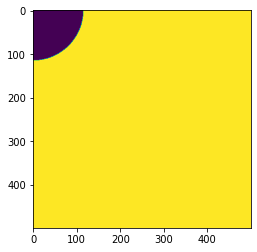

In [33]:
fig,ax = figax()
ax.imshow(real(mask)[pts//2:,pts//2:])

## Test

In [12]:
## physics and lens params
lmbda = 8.05e-7
k = 2*pi/lmbda
f1 = .5 # lens focal length [m]
f2 = 0.005
A0 = 1 # input field amplitude

## input mask grid params
xnum = ynum = 10 # number of grid points in each dimension
pts = 1100 # grid mesh is pts x pts

In [16]:
# Gaussian beam array object.
param_names = ['type','a1','tb1','ta1','dx','dy','a2','tb2','phi_std','pos_std']
gba = namedtuple('gba',param_names,defaults=[None,None,None,None])

In [27]:
array = gba('bright',1e-4,0,sqrt(1),4.3e-4,4.3e-4)
# name,a,t,r,dx,dy = array
array

gba(type='bright', a1=0.0001, tb1=0, ta1=1.0, dx=0.00043, dy=0.00043, a2=None, tb2=None, phi_std=None, pos_std=None)

In [32]:
# reproduce standard bright array and save the image data

# list of gba configurations over which to iterate
configurations = [gba('bright',1e-4,0,sqrt(1),4.3e-4,4.3e-4)]#,
#                   gba('bright_asym',1e-4,0,0,4.3e-4,1.22*4.3e-4)]

b=0.002455, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000046, zTalboty=0.000046
step 0 completed


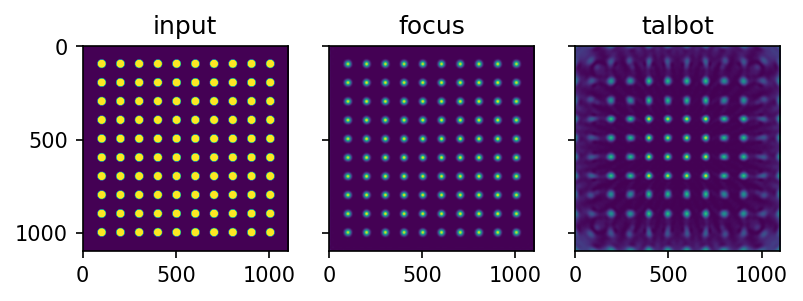

In [33]:
plot=True
savedata=False

labels = ['input','focus','talbot'] # output axial plane

for i,cfg in enumerate(configurations):
    
    # extract the array params
    name,a1,tb1,ta1,dx,dy,a2,tb2,phi_std,pos_std = [
        getattr(cfg, attr) for attr in param_names]

    # calculate the Talbot lengths
    Lx2 = f2*dx/f1 # output array periodicity
    Ly2 = f2*dy/f1
    zTalbotx = 2*Lx2**2/lmbda 
    zTalboty = 2*Ly2**2/lmbda
    b = f1*3.8317/(a1*k) # fourier plane filter radius
        
    # create the mask
    
    if name == 'bright_dark':
        
        mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                               phi_std=phi_std, pos_std=pos_std, 
                               aperture=ta1, plate=tb1)
        
        # make a plate with 0s in the background and spots = -tb1, 
        # so adding this to the plate we just made will complete the 
        # bright-dark mask
        phi_std=None # [rad]
        pos_std=None
        t12 = 0 # plate transmissivity
        mask2, x0pts, w = spot_mask(xnum, ynum, a2, dx, dy, pts, 
            phi_std=phi_std, pos_std=pos_std, aperture=-tb1, plate=t12)

        # need to offset mask2
        offset_pts= int(pts/(xnum+1)/2)
        mask2_offset = zeros((pts,pts),complex)
        for i in range(pts):
            for j in range(pts):
                if i + offset_pts < pts and j + offset_pts < pts: 
                    mask2_offset[i + offset_pts,j + offset_pts] = mask2[i,j]
        
        # offset the total mask to be more centered now
        mask_total = mask + mask2_offset
        offset_final_pts = int(offset_pts/2)
        mask_total_offset = full((pts,pts),tb1,complex)
        for i in range(pts):
            for j in range(pts):
                if i - offset_pts > 0 and j - offset_pts > 0: 
                    mask_total_offset[i - offset_final_pts,j - offset_final_pts] = mask_total[i,j]
        
        mask = mask_total_offset
        b = f1*3.8317/(max(a1,a2)*k)
        
        print(f'b={b:0.6f}, a_dark={a1}, a_bright={a2}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
        print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
        
    else:
        
        mask, x0pts, w = spot_mask(xnum, ynum, a1, dx, dy, pts, 
                               phi_std=phi_std, pos_std=pos_std, 
                               aperture=ta1, plate=tb1)
        
        print(f'b={b:0.6f}, a={a1}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
        print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')
        
    field0 = mask
    
    # SAVE THE INPUT MASK
        
    #todo
        
    # FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
    padding = pts//2 # int(3*pts/2) #TODO set
    rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
    field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding, masked=False,
                              padval=1,logging=False)

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    padding = pts//2

    # axial output planes to probe
    zvals = [f2, f2 + min(zTalbotx, zTalboty)]

    for z2 in zvals: 

        field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                                 logging=False)

        if z2 == f2:
            focal_field = field2
        else:
            talbot_field = field2
           
    if plot:
        fig,axes = plt.subplots(ncols=3,sharey=True,dpi=150)

    metadata=f"lambda={lmbda}, f1={f1}, f2={f2}, xnum={xnum}, ynum={ynum}, a1={a1}, dx={dx}, \
        dy={dy}, pts={pts}, phi_std={phi_std}, pos_std={pos_std}, \
        ta1={ta1}, tb1={tb1}, a2={a2}, tb2={tb2}, zTalbotx={zTalbotx}, \
        zTalboty={zTalboty}"
    
    for l,field,z2,ax in zip(
        labels,[field0,focal_field,talbot_field],[0]+zvals,axes):
        I2_xy = conjugate(field)*field
        if z2 == f2 or z2 == 0:
            I2xy_max = amax(I2_xy)
        I2_xy /= I2xy_max
        I2_xy = real(I2_xy)

        # plot
        if plot:
            mmscl = 1e3
            ax.set_title(l)
#             ax.set_aspect('equal')
            cax = ax.imshow(I2_xy) #,extent=[-w*mmscl,w*mmscl,-w*mmscl,w*mmscl])
            cax.set_norm(colors.Normalize(vmin=0, vmax=1))    
        
        if savedata:
            fname = f'test_{name}_{l}_{int(time())}.csv'
            filepath = os.path.join(imagedir,fname)
            soln_to_csv(filepath, I2_xy, labels=False, metastr=metadata)
            
print(f"step {i} completed")

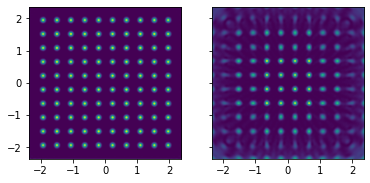

In [34]:
# SAVE OUTPUT INTENSITIES

fig,axes = plt.subplots(ncols=2,sharey=True)

for output_field,z2,ax in zip([focal_field,talbot_field],zvals,axes):
    I2_xy = conjugate(output_field)*output_field
    if f2 - z2 == 0:
        I2xy_max = amax(I2_xy)
    I2_xy /= I2xy_max
    I2_xy = real(I2_xy)

    # plot
    
#     ax.set_title(rf'Intensity') #$t_{{spot}}$={1-r_aper:0.2f}, $t_{{plate}}$={t_plate:0.2f}',)
    mmscl = 1e3
    ax.set_aspect('equal')
    cax = ax.imshow(I2_xy,extent=[-w*mmscl,w*mmscl,-w*mmscl,w*mmscl])
    cax.set_norm(colors.Normalize(vmin=0, vmax=1))
#     cbar = fig.colorbar(cax)

#         save intensity data as a csv

In [ ]:
fig,axes = plt.subplots((1,2),sharey=True)

### low level tests

In [168]:
## functions to save array data

# only store non-complex data

def soln_to_csv(fname, data, labels, metastr=None):
    """
    Args:
        fname: myfile.csv
        data: a list or array of equal length lists or arrays of data
        labels: a label describing each list in data. None by default.
    
        e.g., 
        data = [array([1,2,3]), array([2,4,6], array([1,4,9]]
        labels = ['x', '2x', 'x^2']
    """
    
    
    if type(data) == np.ndarray:
    # listify to avoid malforming strings
        data = [d for d in data]
    
    with open(fname, 'w', newline='') as f:
        writer = csv.writer(f, delimiter=',')

        if metastr:
            writer.writerow([metastr])
        
        if labels:
            for d,l in zip(data, labels):
                writer.writerow([l] + list(d))
        
        else:
            for d in data:
                writer.writerow(d)
            
    print(f"wrote data to {fname}")

def soln_from_csv(fname, labels=True, metastr=False, datatype=complex):
    """
    Args:
        fname: myfile.csv
        labels: if True, assume the zeroth element of each row
        contains labels for the columns of data
        metastr: if True, will interpret the first row of the data as
        a string which is not part of the data. False by default
        datatype: a python datatype. complex by default
    Returns:
        data: an array of equal length arrays of data
        labels: a label describing each array in data if labels is True
        metadata: if metastr is True, a str found at the start of the file
    
        e.g. 
            data = [array([1,2,3]), array([2,4,6], array([1,4,9]]
            labels = ['x', '2x', 'x^2']
            metadata = 'something about my data'
            
            
    """
    labels = []
    data = []
    
    with open(fname, 'r', newline='') as f:
        reader = csv.reader(f, delimiter=',')
        if metastr:
            metadata = next(reader)
        
        idx = 1 if labels else 0
        
        for row in reader:
            if labels:
                labels.append(row[0])
            try:
                data.append(np.array([datatype(x) for x in row[idx:]]))
            except (ValueError,TypeError) as e:
                print(e)
                print(f"problematic row: {row}")
                break
    
    if labels and metastr:
        return data, labels, metadata
    if labels:
        return data, labels
    if metastr:
        return data, metadata
    else: 
        return data

In [118]:
datatype = complex

In [119]:
type(1+1j) == datatype

True

In [112]:
labels = False
idx

0

In [87]:
[f.shape for f in field2[:5]]

[(1100,), (1100,), (1100,), (1100,), (1100,)]

In [95]:
metadata = f"lambda={lmbda}, f1={f1}, f2={f2}, xnum={xnum}, ynum={ynum}, a1={a1}, dx={dx}, \
dy={dy}, pts={pts}, phi_std={phi_std}, pos_std={pos_std}, \
r1={r1}, t1={t1}, a2={a2}, r2={r2}"

In [96]:
metadata

'lambda=8.05e-07, f1=0.5, f2=0.005, xnum=10, ynum=10, a1=0.0001, dx=0.00043, dy=0.00043, pts=1100, phi_std=None, pos_std=None, r1=0, t1=0, a2=None, r2=None'

In [109]:
abs(1+1j)

1.4142135623730951

In [110]:
# test function saving

fname = 'test.csv'
filepath = os.path.join(imagedir,fname)
soln_to_csv(filepath,abs(talbot_field),labels=None,metastr=metadata)

wrote data to .\paper_data\test.csv


In [121]:
data, metastr = soln_from_csv(filepath,labels=False,metastr=True,
                              datatype=float)

In [122]:
metastr

['lambda=8.05e-07, f1=0.5, f2=0.005, xnum=10, ynum=10, a1=0.0001, dx=0.00043, dy=0.00043, pts=1100, phi_std=None, pos_std=None, r1=0, t1=0, a2=None, r2=None']

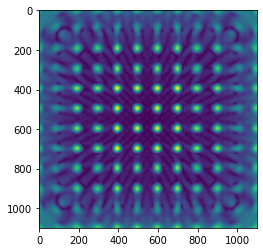

In [123]:
plt.imshow(data)